## Ridge objective parametrizations and intercept handling

The purpose of this notebook is two empirically study two ways to parametrize the Ridge regression problem, with intercept and study the impact with low (and high!) regularization on underdetermined problems.

- **Type "a" ridge** is the one currently implemented in scikit-learn: it fits a **ridge estimator (without intercept) on centered X and y** and computes the intercept from the optimal coef a-posteriori (analytically): `intercept = y_train.mean() - X_train.mean(axis=0) @ coef`. 

- **Type "b" ridge horizontally concatenates a constant column of 1 to X**, and the solve for the ridge using standard least squares with Tikhonov diagonal damping except that the last diagonal element is set to zero to avoid penalizing the intercept.

Both formulations fit a ridge estimator with unpenalized intercept on the original problem and as this notebook shows, both converge to the same solution when alpha is large enough. However, on underdetermined problem their behavior diverge slightly and converge to different minimum norm solution of the OLS problem in the `alpha -> 0` limit:

- **Type "a" OLS does not include the intercept** parameter in the computation of the norm used for the minimum norm objective.
- **Type "b" OLS includes the intercept** parameter in the computation of the norm used for the minimum norm objective.

This notebook serves as a guiding experiment to make a decision for the design of scikit-learn:

- https://github.com/scikit-learn/scikit-learn/pull/25948

As we can see in the following, the discrepency between the 2 types of ridge appears for non-zero values of alpha, as soon as one of the 2 underlying linear algebra system is no longer numerically determined.

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from numpy.testing import assert_allclose
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(0)

# User a large data set to be able many CV iterations from the same
# distribution and average the results.
n_samples_all, n_features = 10_000, 100
n_samples_train = 50

# Use a large intercept in the data generative process because the two
# approaches are different only when fit_intercept=True and matters.
intercept_true = 200.0

X, y_noise_free, coef_true = make_regression(
    n_samples=n_samples_all,
    n_features=n_features,
    n_informative=int(0.8 * n_features),
    noise=0.0,
    coef=True,
    bias=intercept_true,
    random_state=rng,
)
# Quick sanity check.
assert_allclose(X @ coef_true + intercept_true, y_noise_free)

# # Add some noise manually to the target to make the generalization problem less easy.
y = y_noise_free + y_noise_free.std() / 10 * rng.normal(size=n_samples_all)

y.mean(), y.std()

(200.66049258604295, 522.6463231353866)

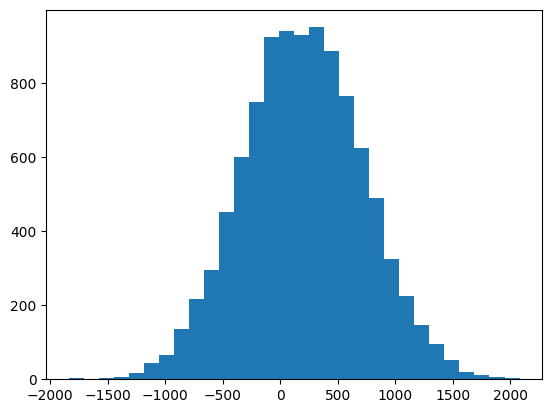

In [2]:
import matplotlib.pyplot as plt

plt.hist(y, bins=30);

We see that the intercept is large enough compared to the range of variation of y. This study requires it because we want to study the impact of intercept estimation by both rige types.

Let's now implement both types of ridge estimators the traditional scikit-learn API:

In [3]:
from sklearn.linear_model import LinearRegression
from numpy.linalg import pinv
from scipy.linalg import lstsq


class MinimalRidge(LinearRegression):
    def __init__(
        self, alpha=1.0, ridge_type="a", solver="pinv", fit_intercept=True, rcond=1e-12
    ):
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.rcond = rcond
        self.ridge_type = ridge_type
        self.solver = solver
        if solver not in ("pinv", "lstsq", "solve"):
            raise ValueError("Solver must be 'pinv', 'lstsq' or 'solve'")

    def fit(self, X, y):
        assert self.fit_intercept, "This experiment only deals with fit_intercept=True"
        if self.ridge_type == "a":
            return self._fit_a(X, y)
        elif self.ridge_type == "b":
            return self._fit_b(X, y)
        else:
            raise ValueError(f"Unknown ridge_type: {self.ridge_type}")

    def _fit_a(self, X, y):
        # Center X and y and compute the intercept the intercept from the
        # solution of the ridge on the centered data. When alpha=0, this
        # converges to the minimum norm OLS where the intercept is not
        # included in the computation of the norm of the solution.
        X_m = X.mean(axis=0)
        X_c = X - X_m
        y_m = y.mean()
        y_c = y - y_m
        if self.solver == "pinv":
            damping_matrix = self.alpha * np.eye(X_c.shape[1])
            self.coef_ = (
                pinv(X_c.T @ X_c + damping_matrix, rcond=self.rcond) @ X_c.T @ y_c
            )
        elif self.solver == "lstsq":
            damping_matrix = np.sqrt(self.alpha) * np.eye(X_c.shape[1])
            self.coef_ = lstsq(
                np.vstack([X_c, damping_matrix]),
                np.concatenate([y_c, np.zeros(X.shape[1])]),
                cond=self.rcond,
            )[0]
        elif self.solver == "solve":
            damping_matrix = self.alpha * np.eye(X_c.shape[1])
            self.coef_ = np.linalg.solve(X_c.T @ X_c + damping_matrix, X_c.T @ y_c)
        else:
            raise ValueError(f"Unknown solver: {self.solver}")
        # Compute the intercept from the solution of the ridge on the centered
        self.intercept_ = y_m - X_m @ self.coef_
        return self

    def _fit_b(self, X, y):
        # Solve for the ridge problem by concatenating the data with a column
        # of 1. Use a damping matrix with a zero value for the last diagonal
        # element (unpenalized intercept). Note when alpha is zero, this
        # converges to the minimum norm OLS problem where the intercept is
        # included in computing the norm of the solution.

        n_samples, n_features = X.shape
        X_with_ones = np.hstack([X, np.ones((n_samples, 1))])
        if self.solver == "pinv":
            damping_matrix = self.alpha * np.eye(n_features + 1)
            damping_matrix[-1, -1] = 0  # unpenalized intercept
            w = (
                pinv(X_with_ones.T @ X_with_ones + damping_matrix, rcond=self.rcond)
                @ X_with_ones.T
                @ y
            )
        elif self.solver == "lstsq":
            damping_matrix = np.sqrt(self.alpha) * np.eye(n_features + 1)
            damping_matrix[-1, -1] = 0  # unpenalized intercept
            w = lstsq(
                np.vstack([X_with_ones, damping_matrix[:-1]]),
                np.concatenate([y, np.zeros(n_features)]),
                cond=self.rcond,
            )[0]
        elif self.solver == "solve":
            damping_matrix = self.alpha * np.eye(n_features + 1)
            damping_matrix[-1, -1] = 0  # unpenalized intercept
            w = np.linalg.solve(X_with_ones.T @ X_with_ones + damping_matrix, X_with_ones.T @ y)
        else:
            raise ValueError(f"Unknown solver: {self.solver}")
        self.coef_ = w[:-1]
        self.intercept_ = w[-1]
        return self

In [4]:
# Fixed split to run some sanity checks on a small training set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, train_size=n_samples_train
)

In [5]:
# Sanity check #0, check that both models can perfectly fit the training data
# with no regularization as n_samples_train is small.
assert_allclose(MinimalRidge(alpha=0.0, ridge_type="a").fit(X_train, y_train).score(X_train, y_train), 1.0)
assert_allclose(MinimalRidge(alpha=0.0, ridge_type="b").fit(X_train, y_train).score(X_train, y_train), 1.0)

In [6]:
# Sanity check #1, check that both models can reach the expected high
# penalization limit model, and in particular that the intercept is effectively
# not penalized.
for solver in ["pinv", "lstsq", "solve"]:
    ridge_a = MinimalRidge(alpha=1e12, ridge_type="a", solver=solver).fit(X_train, y_train)
    assert_allclose(ridge_a.coef_, 0.0, atol=1e-7)
    assert_allclose(ridge_a.intercept_, y_train.mean())

    ridge_a = MinimalRidge(alpha=1e30, ridge_type="a", solver=solver).fit(X_train, y_train)
    assert_allclose(ridge_a.coef_, 0.0, atol=1e-12)
    assert_allclose(ridge_a.intercept_, y_train.mean())

In [7]:
for solver in ["pinv", "lstsq", "solve"]:
    ridge_b = MinimalRidge(alpha=1e12, ridge_type="b", solver=solver)
    ridge_b.fit(X_train, y_train)
    assert_allclose(ridge_b.coef_, 0.0, atol=1e-7)
    assert_allclose(ridge_b.intercept_, y_train.mean(), rtol=1e-6)

    ridge_b = MinimalRidge(alpha=1e30, ridge_type="b", solver=solver)
    ridge_b.fit(X_train, y_train)
    assert_allclose(ridge_b.coef_, 0.0, atol=1e-12)

    # XXX: the following unexpectedly fails: the intercept stays very close to 0
    # instead of being the mean of the target. Making it work would probably
    # require to finely adjust rcond to the value of alpha...

    # assert_allclose(ridge_b.intercept_, y_train.mean())

In [8]:
# Sanity check #2, check that Ridge type "a" matches scikit-learn's Ridge
from timeit import default_timer
from sklearn.linear_model import Ridge

for solver in ["pinv", "lstsq", "solve"]:
    for alpha in [0., 0.001, 0.01, 0.1, 1., 10., 100.]:
        start = default_timer()
        coef_diff = np.linalg.norm(
            MinimalRidge(alpha=alpha, ridge_type="a", solver=solver).fit(X_train, y_train).coef_ -
            Ridge(alpha=alpha, solver="lsqr", tol=1e-12).fit(X_train, y_train).coef_
        )
        end = default_timer()
        print(f"{solver = } - {alpha = :0.1e}: {coef_diff = :0.1e} in {(end - start)*1e3:0.1f} ms", end="")
        if coef_diff < 1e-5:
            print(" - PASS")
        else:
            print(" - FAIL")

# XXX: The lstsq solver is not as stable as the pinv solver. Or maybe the lsqr
# way we use the lsqr solver in scikit-learn is the culprit?

solver = 'pinv' - alpha = 0.0e+00: coef_diff = 3.9e-09 in 7.3 ms - PASS
solver = 'pinv' - alpha = 1.0e-03: coef_diff = 1.8e-08 in 6.2 ms - PASS
solver = 'pinv' - alpha = 1.0e-02: coef_diff = 1.8e-09 in 5.7 ms - PASS
solver = 'pinv' - alpha = 1.0e-01: coef_diff = 1.7e-10 in 6.0 ms - PASS
solver = 'pinv' - alpha = 1.0e+00: coef_diff = 3.3e-10 in 4.4 ms - PASS
solver = 'pinv' - alpha = 1.0e+01: coef_diff = 3.8e-10 in 3.4 ms - PASS
solver = 'pinv' - alpha = 1.0e+02: coef_diff = 4.3e-10 in 2.7 ms - PASS
solver = 'lstsq' - alpha = 0.0e+00: coef_diff = 3.9e-09 in 4.5 ms - PASS
solver = 'lstsq' - alpha = 1.0e-03: coef_diff = 2.3e-11 in 3.8 ms - PASS
solver = 'lstsq' - alpha = 1.0e-02: coef_diff = 3.7e-11 in 5.4 ms - PASS
solver = 'lstsq' - alpha = 1.0e-01: coef_diff = 3.3e-11 in 6.7 ms - PASS
solver = 'lstsq' - alpha = 1.0e+00: coef_diff = 3.3e-10 in 5.9 ms - PASS
solver = 'lstsq' - alpha = 1.0e+01: coef_diff = 3.8e-10 in 4.9 ms - PASS
solver = 'lstsq' - alpha = 1.0e+02: coef_diff = 4.3e-10 in

In [11]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

# The rest of the analysis will be conducted for a single solver. Feel free to
# comment/uncomment the definition of the `solver` parameter, restart and run
# all cells to check that the conclusions are robust to the choice of the
# solver.

#  solver = "lstsq"
solver = "pinv"

info = []
for split_idx in range(3):
    print(f"Split #{split_idx}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=split_idx, train_size=n_samples_train
    )

    for ridge_type in ["a", "b"]:
        ols = MinimalRidge(alpha=0, ridge_type=ridge_type, solver=solver)
        ols.fit(X_train, y_train)
        ols_params = np.concatenate([ols.coef_, [ols.intercept_]])
        ols_test_preds = ols.predict(X_test)

        for alpha in tqdm(np.r_[0, np.logspace(-20, 20, 1000)]):
            ridge = MinimalRidge(alpha=alpha, ridge_type=ridge_type, solver=solver)
            ridge.fit(X_train, y_train)
            ridge_params = np.concatenate([ridge.coef_, [ridge.intercept_]])
            info.append(
                {
                    "split_idx": split_idx,
                    "ridge_type": ridge_type,
                    "alpha": alpha,
                    "coef": ridge.coef_,
                    "intercept": ridge.intercept_,
                    "params": ridge_params,
                    "param_dist_to_ols": np.linalg.norm(ridge_params - ols_params),
                    "pred_dist_to_ols": np.linalg.norm(ridge.predict(X_test) - ols_test_preds),
                    "train_mse": mean_squared_error(y_train, ridge.predict(X_train)),
                    "train_r2": ridge.score(X_train, y_train),
                    "test_mse": mean_squared_error(y_test, ridge.predict(X_test)),
                    "test_r2": ridge.score(X_test, y_test),
                }
            )
    print()
info = pd.DataFrame(info)

Split #0


  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]


Split #1


  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]


Split #2


  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

In [13]:
info

,split_idx,ridge_type,alpha,coef,intercept,params,param_dist_to_ols,pred_dist_to_ols,train_mse,train_r2,test_mse,test_r2
0,0,a,0.000000e+00,"[-19.900592446803667, 28.006634216031426, 40.9...",1.714066e+02,"[-19.900592446803667, 28.006634216031426, 40.9...",0.000000,0.000000,5.107197e-25,1.000000,160026.413469,0.414971
1,0,a,1.000000e-20,"[-19.900592446803667, 28.006634216031426, 40.9...",1.714066e+02,"[-19.900592446803667, 28.006634216031426, 40.9...",0.000000,0.000000,5.107197e-25,1.000000,160026.413469,0.414971
2,0,a,1.096579e-20,"[-19.900592446803667, 28.006634216031426, 40.9...",1.714066e+02,"[-19.900592446803667, 28.006634216031426, 40.9...",0.000000,0.000000,5.107197e-25,1.000000,160026.413469,0.414971
3,0,a,1.202486e-20,"[-19.900592446803667, 28.006634216031426, 40.9...",1.714066e+02,"[-19.900592446803667, 28.006634216031426, 40.9...",0.000000,0.000000,5.107197e-25,1.000000,160026.413469,0.414971
4,0,a,1.318621e-20,"[-19.900592446803667, 28.006634216031426, 40.9...",1.714066e+02,"[-19.900592446803667, 28.006634216031426, 40.9...",0.000000,0.000000,5.107197e-25,1.000000,160026.413469,0.414971
...,...,...,...,...,...,...,...,...,...,...,...,...
6001,2,b,6.915759e+19,"[-6.580617647277228e-17, 2.378953654701381e-17...",-5.806111e-32,"[-6.580617647277228e-17, 2.378953654701381e-17...",391.823836,39099.242477,2.987054e+05,-0.238228,313497.774351,-0.147033
6002,2,b,7.583678e+19,"[-6.001041328866471e-17, 2.16943149815547e-17,...",6.313981e-32,"[-6.001041328866471e-17, 2.16943149815547e-17,...",391.823836,39099.242477,2.987054e+05,-0.238228,313497.774351,-0.147033
6003,2,b,8.316104e+19,"[-5.472510174734712e-17, 1.9783626368206146e-1...",-2.690923e-32,"[-5.472510174734712e-17, 1.9783626368206146e-1...",391.823836,39099.242477,2.987054e+05,-0.238228,313497.774351,-0.147033
6004,2,b,9.119268e+19,"[-4.990528471869709e-17, 1.8041218291960702e-1...",-4.389204e-33,"[-4.990528471869709e-17, 1.8041218291960702e-1...",391.823836,39099.242477,2.987054e+05,-0.238228,313497.774351,-0.147033


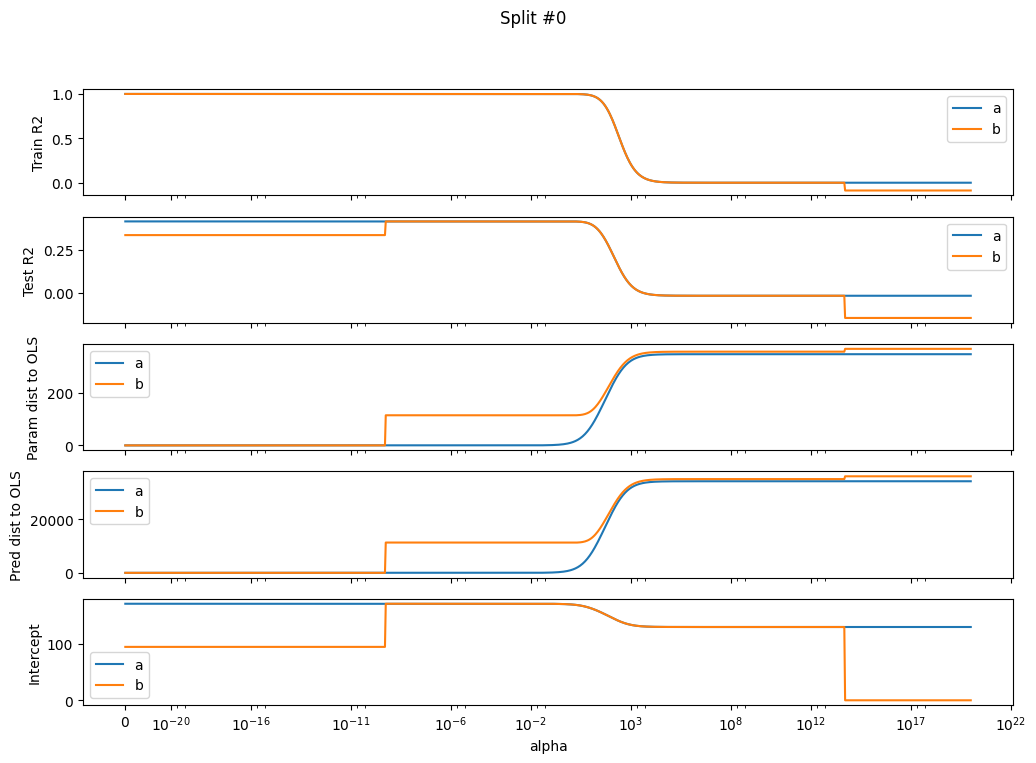

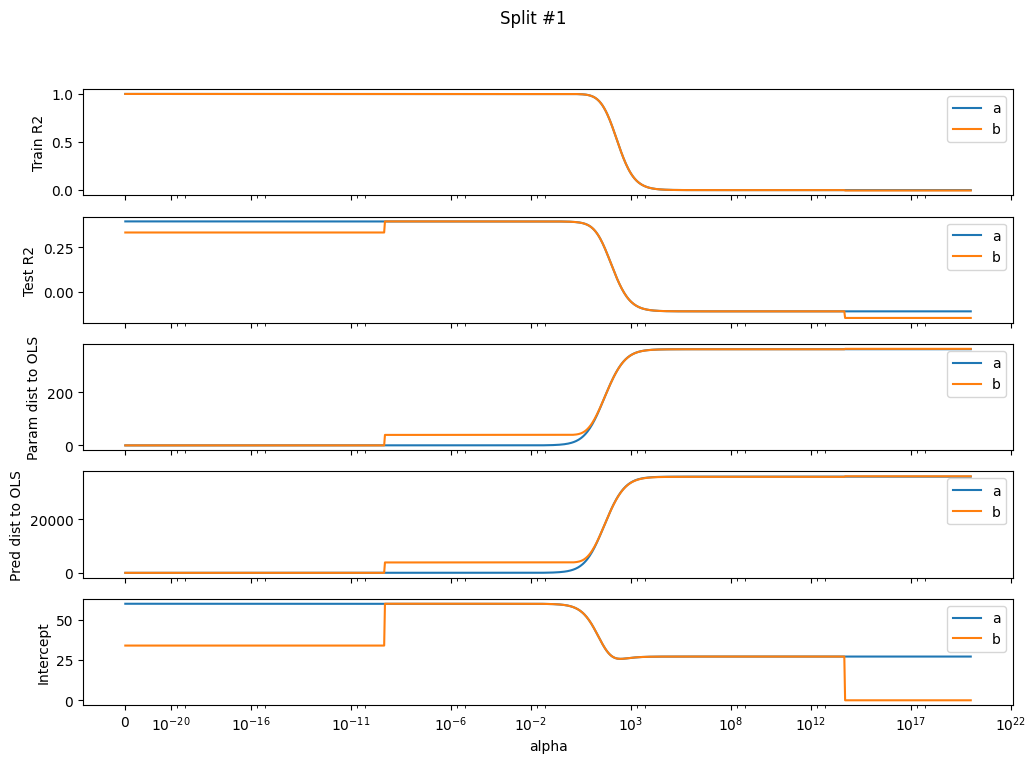

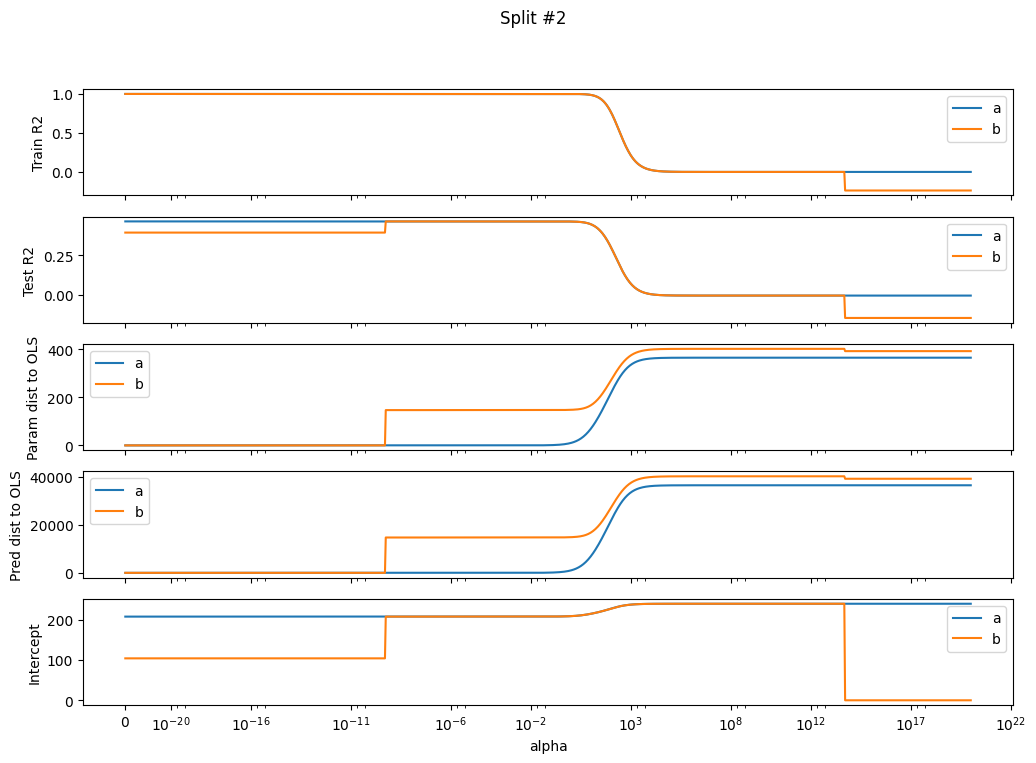

In [29]:
import matplotlib.pyplot as plt

metrics_plot_params = [
    # {"metric": "train_mse", "ylabel": "Train MSE", "yscale": "log"},
    # {"metric": "test_mse", "ylabel": "Test MSE", "yscale": "log"},
    {"metric": "train_r2", "ylabel": "Train R2", "yscale": "linear"},
    {"metric": "test_r2", "ylabel": "Test R2", "yscale": "linear"},
    {"metric": "param_dist_to_ols", "ylabel": "Param dist to OLS", "yscale": "linear"},
    {"metric": "pred_dist_to_ols", "ylabel": "Pred dist to OLS", "yscale": "linear"},
    {"metric": "intercept", "ylabel": "Intercept", "yscale": "linear"},
]

for split_idx, split_info in info.groupby("split_idx"):
    fig, axes = plt.subplots(nrows=len(metrics_plot_params), figsize=(12, 8), sharex=True)
    # axes[0].set_xscale("log")  # alpha in log space
    axes[0].set_xscale('asinh', linear_width=1e-22)  # alpha in log space
    fig.suptitle(f"Split #{split_idx}")
    for metric_plot_params, ax in zip(metrics_plot_params, axes):
        for ridge_type in ["a", "b"]:
            ax.set(ylabel=metric_plot_params["ylabel"], yscale=metric_plot_params.get("yscale", "linear"))
            split_info.query("ridge_type == @ridge_type").plot(x="alpha", y=metric_plot_params["metric"], label=ridge_type, ax=ax)

plt.legend();

## Analysis

- Both type a and type b ridge formulations converge to the same solution for a wide range of intermediate values of alpha (explicitly checked in the end of this notebook).
- Both type a and type b ridge formulations reach their own OLS limit (type a or type b), however the **type "b" formulation fails to continuously progress to the type "b" minimal norm OLS solution**: indeed we can always observe a discontinuity when alpha is around 1e-9...
- Type a and type b OLS are different (as expected) and in general, type a OLS seems to be more correct (lower test MSE / higher test R2) more often (but it depends on the sampling of the training set).
- More suprisingly, type b ridge also has a numerical discontinuity towards infinitely regularized models: it fails to converge to the constant `y_train.mean()` prediction because of numerical unstability in the estimation of the intercept: for highly regularization models, this estimator finds near-zero intercept values instead... This is completely wrong.
- Both discontinuities of the type "b" ridge formulation seem to stem from numerically unstable estimation of the intercept at low or high alpha values as can be seen on the last row of the above plot.

- [x] TODO: confirm that those conclusions still hold with alternative numerical solvers (e.g. `scipy.linalg.lstsq` with properly set `cond` parameter to threshold the near zero singular values appropriately as we do with the current `pinv` based solver that also relies on an SVD solver). => done: the previous conclusions are the same, although the `lstsq`-based implemetnation does not seem as stable as the `pinv` based implementation (as reported in the sanity checks).

- [ ] TODO: but even more work: implement both ridge types with `scipy.sparse.linalg.lsqr` or `scipy.sparse.linalg.lsmr` instead.


In the following we check that both ridge estimator converge to the same solution for intermediate values of alpha:

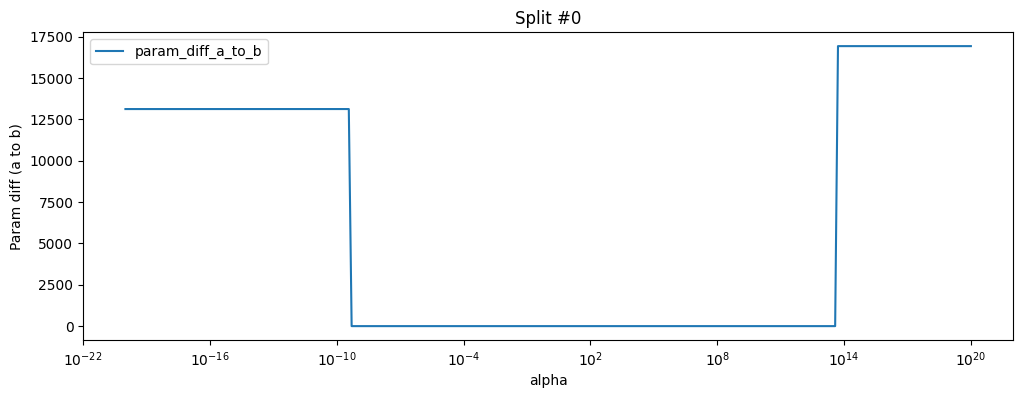

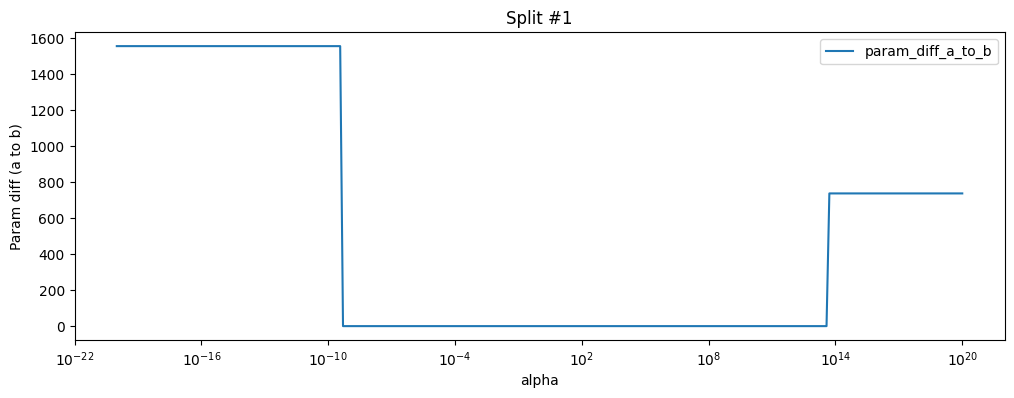

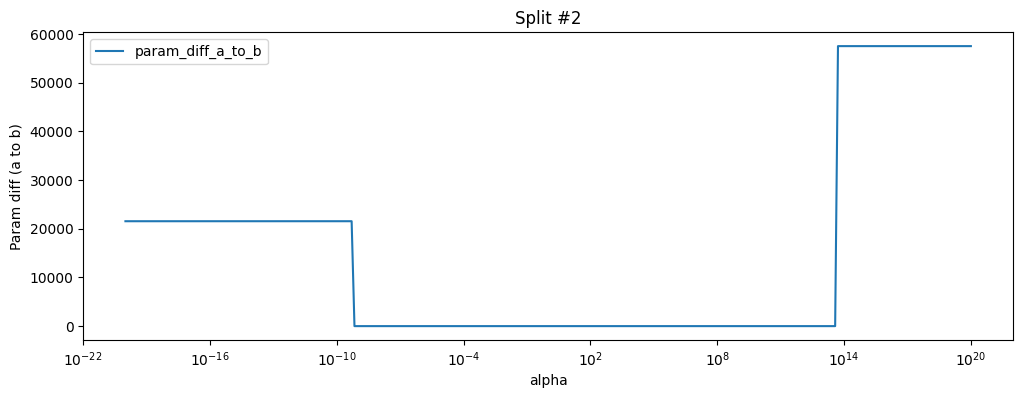

In [11]:
info_a = (
    info.query("ridge_type == 'a'").sort_values(["split_idx", "alpha"]).reset_index()
)
info_b = (
    info.query("ridge_type == 'b'").sort_values(["split_idx", "alpha"]).reset_index()
)

param_diff = np.vstack(info_a["params"] - info_b["params"])
info_a["param_diff_a_to_b"] = (param_diff**2).sum(axis=1)

for split_idx, split_info in info_a.groupby("split_idx"):
    split_info.plot(
        x="alpha",
        y="param_diff_a_to_b",
        logx=True,
        figsize=(12, 4),
        title=f"Split #{split_idx}",
        ylabel="Param diff (a to b)",
    )
